# 3: Multivariate Analysis

In this lesson we will use 'Multivariate Analysis' to improve the signal significance of our data sample. This involves training a Boosted Decision Tree (**BDT**) which can distinguish between signal-like and background-like events. The BDT takes a number of input variables and makes a prediction on whether the event is signal or background.

* First we need to load the data which we stored in the previous lesson and import the modules we need:

In [1]:
%store -r bkg_df
%store -r mc_df
%store -r data_df

In [2]:
from matplotlib import pyplot as plt
import uproot4 as uproot
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

## Using a classifier

Rectangular cuts are give good simple selections however you can often get better performance by using a more advanced technique. This generally works by taking adavantage of the corellation between variables. For example if we look in two dimensions, `Jpsi_eta` and `mum_P`:

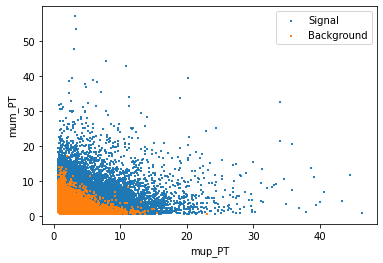

In [3]:
plt.scatter(mc_df['mup_PT'], mc_df['mum_PT'], s=1, marker=',', label='Signal')
plt.scatter(bkg_df['mup_PT'], bkg_df['mum_PT'], s=1, marker=',', label='Background')
plt.xlabel('mup_PT')
plt.ylabel('mum_PT')
plt.legend()

We can see that there if we cut out 2 (or more) dimensional regions we can remove background more effectively. This is the idea behind decision trees.

#### TODO Add a diagram of a decision tree for the above plot

In machine learning there is a concept known as "boosting" which comes from the question:

> Can a set of weak learners create a single strong learner?

I.e. Can a set of bad decision trees be combined to make a single algorithm that has good performance? Luckily the answer is yes and this is known as a boosted ensemable of decision trees. A BDT.
(This can also be done with other classifers but BDT's are popular for solving HEP classification problems.)

This might sound complicated but there is a popular Python package called `scikit-learn` which makes it easy to do machine learning in Python.

* First choose some variables which have good discriminating power for the classifier to use
* For this exercise we will use `GradientBoosingClassifier` from `scikit-learn`

In [4]:
training_columns = [
    'Jpsi_PT',
    'mup_PT', 'mup_eta', 'mup_ProbNNmu',
    'mum_PT', 'mum_eta', 'mum_ProbNNmu',
]
# Store training_columns
%store training_columns

Stored 'training_columns' (list)


In [5]:
# We then define the classifier we want to use
bdt = GradientBoostingClassifier()

In order to teach the BDT what signal and background look like we have to train it using some reference samples. One of the useful things about `scikit-learn` is that all classifiers are trained in the same way, by calling the `fit(X, y)` method. Where `X` is a 2D array of features and `y` is the labels (signal/background/other/...).

* We need to set the background and signal categories for our data:

In [6]:
bkg_df = bkg_df.copy()
bkg_df['catagory'] = 0  # Use 0 for background
mc_df['catagory'] = 1  # Use 1 for signal

In [7]:
# Now merge the data together
training_data = pd.concat([bkg_df, mc_df], copy=True, ignore_index=True)
# Store training_data for later
%store training_data

Stored 'training_data' (DataFrame)


In [8]:
# We can now fit the BDT
bdt.fit(training_data[training_columns], training_data['catagory'])

GradientBoostingClassifier()

Once a classifier has been trained we can apply it to a dataset to get a variable tells us how signal or background like each candidate is. There are a few different functions to do this, but in this case we will use `bdt.predict_proba`.

In [9]:
bdt.predict_proba(data_df[training_columns].head())

array([[0.11268477, 0.88731523],
       [0.28630294, 0.71369706],
       [0.58681309, 0.41318691],
       [0.65955735, 0.34044265],
       [0.3134157 , 0.6865843 ]])

This has returned a $N_\text{samples}$ by $N_\text{classes}$ array. The first column is the 'probability' that the candiate is catagory 0 (background) and the second column is the probability that the candidate is catagory 1 (signal). These probabilities sum to 1 for each event are only valid under certain assumptions which typically don't apply in HEP.

When you have only two classes we typically just use the signal probability and treat it as a continuous variable that is defined between 0 and 1.

In [10]:
# We can now use slicing to select column 1 in the array from for all rows
probabilities = bdt.predict_proba(data_df[training_columns])[:,1]
probabilities

array([0.88731523, 0.71369706, 0.41318691, ..., 0.36839431, 0.26573531,
       0.30684678])

**CHALLENGE:** Add a new column to each of `mc_df`, `bkg_df`, `data_df` and `training_data` called BDT which contains the signal probability of the classifier.

In [11]:
mc_df['BDT'] = bdt.predict_proba(mc_df[training_columns])[:,1]
bkg_df['BDT'] = bdt.predict_proba(bkg_df[training_columns])[:,1]
data_df['BDT'] = bdt.predict_proba(data_df[training_columns])[:,1]
training_data['BDT'] = bdt.predict_proba(training_data[training_columns])[:,1]

Alternatively we can avoid copying the same line of code by taking advantage of the fact that dataframes are mutable. This is a good idea as fewer lines of code normally means fewer chances for bugs. In the lines above we could easily mix up the different `DataFrame` objects which can cause subtle bugs. If it crashes it's okay, but if you accidenatlly use the wrong dataset somewhere and end up with mistakes in your final result.

In [12]:
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT'] = bdt.predict_proba(df[training_columns])[:,1]

**CHALLENGE:** Use your `plot_comparision` function from earlier to compare the BDT response on data and sidebands.

Reload functions from the previous lesson here:

In [13]:
def plot_comparision(var, mc_df, bkg_df):
    _, bins, _ = plt.hist(mc_df[var], bins=100, histtype='step', label='MC', density=1)
    _, bins, _ = plt.hist(bkg_df[var], bins=bins, histtype='step', label='Background', density=1)
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')
    
def plot_mass(df, **kwargs):
    counts, bins, _ = plt.hist(df['Jpsi_M'], bins=100, range=[2.75, 3.5], histtype='step', **kwargs)
    plt.xlabel('$J/\\psi$ mass [GeV]')
    plt.xlim(bins[0], bins[-1])

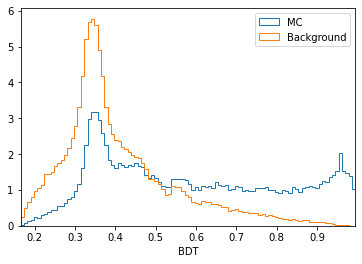

In [14]:
plot_comparision('BDT', mc_df, bkg_df)

We can now choose a cut value and compare it to the selection we used earlier:

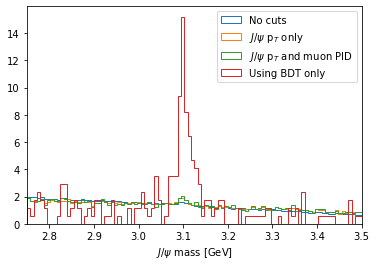

In [15]:
plot_mass(data_df, label='No cuts', density=1)

data_with_cuts_df = data_df.query('Jpsi_PT > 4')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ only', density=1)

data_with_cuts_df = data_df.query('(Jpsi_PT > 4) & ((mum_ProbNNmu > 0.9) & (mup_ProbNNmu > 0.9))')
plot_mass(data_with_cuts_df, label='$J/\\psi$ p$_T$ and muon PID', density=1)

data_with_cuts_df = data_df.query('BDT > 0.95')
plot_mass(data_with_cuts_df, label='Using BDT only', density=1)

plt.legend(loc='best')

**CHALLENGE:** Try to find the best possibly cut on your BDT and compare you score to earlier

In [16]:
# That would be too nice to use in analysis
from python_lesson import check_truth
check_truth(data_df.query('BDT > 0.95'))

Loading reference dataset, this will take a moment...
Data contains 102 signal events
Data contains 126 background events
Significance metric is 8.59


### Evaluating classifier performance

So far we have used a magical function to evalueate the classifier performance. Unfortuanately, we can't use such a tool when using analysis on real data as that would be too easy! Instead, we have a few other tools we can use to see how good a classifier is.


We have already used one tool: the distributions of the classifier output on signal and background training data.

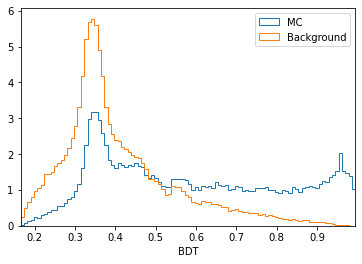

In [17]:
plot_comparision('BDT', mc_df, bkg_df)

From this you can guess find a cut which removes some background while keeping almost all of the signal signal.

Another tool we have the the Receiver Operating Characteristic curve, also known as the ROC curve. This shows the effiency of the classifier on signal (true positive rate, `tpr`) against the ineffieicny of removing background (false positive rate, `fpr`). Each point on this curve corropsonds to a cut value threshold.

To do this we can reuse the training data:

In [18]:
y_score = bdt.predict_proba(training_data[training_columns])[:,1]
fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

We can make the plot look nicer by:
 - Adding axis labels
 - Forcing the grid to be square
 - Adding a line which corrosponds to randomly guessing

If the ROC curve goes close to or below this gray line it means the classifier is really bad!!!

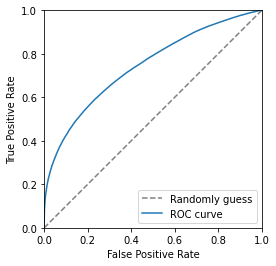

In [19]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Randomly guess')
plt.plot(fpr, tpr, label=f'ROC curve')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

The closer to the top left corner this curve the better the classifier is, another way of looking at this is the area under this curve. Let's add this it to the legend.

In [20]:
area = auc(fpr, tpr)

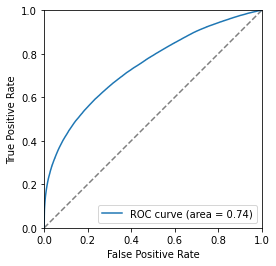

In [21]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

Another thing we can consider is the significance of the signal. Multiple different metrics can be used for this but the most popular generanl purpose metric is $\frac{S}{\sqrt{S+B}}$, where $S$ is the number of signal events and $B$ is the number of background events. It is important to be careful when defining $S$ and $B$ so that is is only includes the number of events under the signal peak. This is often done by taking a range such within $\pm 2 \sigma$ of the peak.

For the toy dataset used here appropriate numbers are:

In [22]:
n_sig = 1200
n_bkg = 23000

We can use these numbers to plot the significance as a function of cut value. The number of signal events after the cut, $S$ is $N_\text{sig} \times \text{true positive rate}$. The number of background events after the cut, $B$ is $N_\text{bkg} \times \text{false positive rate}$. 

In [23]:
S = n_sig*tpr
B = n_bkg*fpr
metric = S/np.sqrt(S+B)

<ipython-input-23-c866fa8b2c52>:3: RuntimeWarning: invalid value encountered in true_divide
  metric = S/np.sqrt(S+B)


Then plots this as a function of the cut value

(0.0, 1.0)

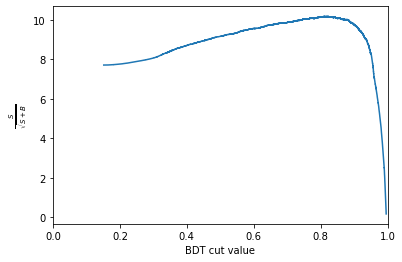

In [24]:
plt.plot(thresholds, metric)
plt.xlabel('BDT cut value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlim(0, 1.0)

**CHALLENGE:** Get the cut value corrosponding to the peak of this curve and plot the mass peak for that cut value

In [25]:
optimal_index = np.argmax(metric)
optimal_metric = metric[optimal_index]
optimal_cut = thresholds[optimal_index]
print(f'The optimal cut value is {optimal_cut:.2f} with and S/sqrt(S+B) of {optimal_metric:.2f}')

The optimal cut value is 2.00 with and S/sqrt(S+B) of nan


/home/jonas/anaconda3/envs/starterkit38/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


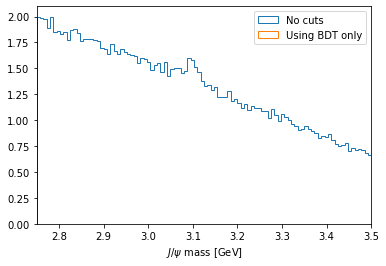

In [26]:
plot_mass(data_df, label='No cuts', density=1)

data_with_cuts_df = data_df.query(f'BDT > {optimal_cut}')
plot_mass(data_with_cuts_df, label='Using BDT only', density=1)

plt.legend(loc='best')

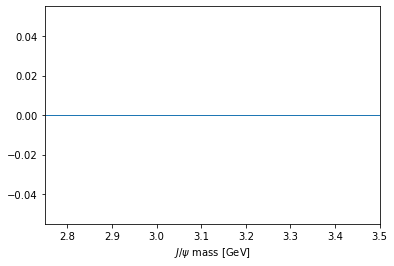

In [27]:
plot_mass(data_with_cuts_df, label='Using BDT only')

### Collecting it all together

Let's define some helpful functions that we use later based on what we did above:

In [28]:
def plot_roc(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

In [29]:
def plot_significance(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

    n_sig = 1200
    n_bkg = 23000
    S = n_sig*tpr
    B = n_bkg*fpr
    metric = S/np.sqrt(S+B)

    plt.plot(thresholds, metric, label=label)
    plt.xlabel('BDT cut value')
    plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
    plt.xlim(0, 1.0)

    optimal_cut = thresholds[np.argmax(metric)]
    plt.axvline(optimal_cut, color='black', linestyle='--')

In [30]:
data_df = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/real_data.root',
                      httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                      )['DecayTree'].arrays(library='pd')
mc_df = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/simulated_data.root',
                    httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                    )['DecayTree'].arrays(library='pd')
print("Data succesfully loaded")
bkg_df = data_df.query('~(3.0 < Jpsi_M < 3.2)').copy()

for df in [mc_df, data_df, bkg_df]:
    df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
    df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
    df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)

training_columns = [
    'Jpsi_PT',
    'mup_PT', 'mup_eta', 'mup_ProbNNmu', 'mup_IP',
    'mum_PT', 'mum_eta', 'mum_ProbNNmu', 'mum_IP',
]

bkg_df['catagory'] = 0  # Use 0 for background
mc_df['catagory'] = 1  # Use 1 for signal
training_data = pd.concat([bkg_df, mc_df], copy=True, ignore_index=True)

bdt = GradientBoostingClassifier()
bdt.fit(training_data[training_columns], training_data['catagory'])

mc_df['BDT'] = bdt.predict_proba(mc_df[training_columns])[:,1]
bkg_df['BDT'] = bdt.predict_proba(bkg_df[training_columns])[:,1]
data_df['BDT'] = bdt.predict_proba(data_df[training_columns])[:,1]
training_data['BDT'] = bdt.predict_proba(training_data[training_columns])[:,1]

plt.figure()
plot_comparision('BDT', mc_df, bkg_df)

plt.figure()
plot_significance(bdt, training_data, training_columns)

plt.figure()
plot_roc(bdt, training_data, training_columns)

OSError: remote server does not support HTTP range requests
for URL https://cern.ch/starterkit/data/advanced-python-2018/real_data.root

In [ ]:
%store bkg_df
%store mc_df
%store data_df